In [1]:
import pandas as pd
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig, AutoModelWithLMHead
import numpy as np
from scipy.special import softmax
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
import prince

In [2]:
reddit_comments_df=pd.read_csv('reddit_comments_sentiment_scores_hugging_face(twitter)')
reddit_comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251097 entries, 0 to 251096
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   body              251097 non-null  object 
 1   post_date         251097 non-null  object 
 2   upvotes           251097 non-null  int64  
 3   parent_id         186502 non-null  object 
 4   top_level_id      251097 non-null  object 
 5   post_title        251097 non-null  object 
 6   post_id           251097 non-null  object 
 7   post_create_date  251097 non-null  object 
 8   movie_searched    251097 non-null  object 
 9   release_date      251097 non-null  object 
 10  date_diff         251097 non-null  int64  
 11  cleaned_body      251097 non-null  object 
 12  negative          251097 non-null  float64
 13  neutral           251097 non-null  float64
 14  positive          251097 non-null  float64
dtypes: float64(3), int64(2), object(10)
memory usage: 28.7+ MB


In [3]:
reddit_comments_df.head()

,body,post_date,upvotes,parent_id,top_level_id,post_title,post_id,post_create_date,movie_searched,release_date,date_diff,cleaned_body,negative,neutral,positive
0,"Damn, even Scorsese pirated Yeezus.",2013-06-17 14:27:18,697,NaN,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9,2013-06-17 05:52:41,The Wolf of Wall Street,2013-12-25,190,Damn even Scorsese pirated Yeezus.,0.715306,0.249625,0.035069
1,[Leo loves it though] (http://i.imgur.com/cPTI...,2013-06-17 18:53:59,168,cakjh4s,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9,2013-06-17 05:52:41,The Wolf of Wall Street,2013-12-25,190,Leo loves it though,0.009015,0.117677,0.873307
2,[Not as much as Ethan Suplee](http://i.imgur.c...,2013-06-17 19:16:00,71,cakpae0,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9,2013-06-17 05:52:41,The Wolf of Wall Street,2013-12-25,190,Not as much as Ethan Suplee,0.216958,0.735043,0.047999
3,"Please put ""white people"" over this.",2013-06-17 19:56:29,25,cakpae0,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9,2013-06-17 05:52:41,The Wolf of Wall Street,2013-12-25,190,Please put white people over this.,0.784111,0.201691,0.014198
4,[close up of dat face](http://i.imgur.com/bcWb...,2013-06-17 19:16:55,3,cakpae0,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9,2013-06-17 05:52:41,The Wolf of Wall Street,2013-12-25,190,close up of dat face,0.114810,0.778931,0.106259


In [4]:
top_200_comments_by_movie = reddit_comments_df.groupby('post_id').apply(lambda x: x.nlargest(200, 'upvotes')).reset_index(drop=True)
top_200_comments_by_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140876 entries, 0 to 140875
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   body              140876 non-null  object 
 1   post_date         140876 non-null  object 
 2   upvotes           140876 non-null  int64  
 3   parent_id         106861 non-null  object 
 4   top_level_id      140876 non-null  object 
 5   post_title        140876 non-null  object 
 6   post_id           140876 non-null  object 
 7   post_create_date  140876 non-null  object 
 8   movie_searched    140876 non-null  object 
 9   release_date      140876 non-null  object 
 10  date_diff         140876 non-null  int64  
 11  cleaned_body      140876 non-null  object 
 12  negative          140876 non-null  float64
 13  neutral           140876 non-null  float64
 14  positive          140876 non-null  float64
dtypes: float64(3), int64(2), object(10)
memory usage: 16.1+ MB


In [5]:
#reddit_comments_df['Sentiment'] = 'neutral'
#reddit_comments_df.loc[reddit_comments_df['positive']>=0.5, "Sentiment"]="postive"
#reddit_comments_df.loc[reddit_comments_df['negative']>=0.5, "Sentiment"]="negative"

reddit_comments_df['sentiment'] = reddit_comments_df[['positive', 'negative', 'neutral']].idxmax(axis=1)
reddit_comments_df['sentiment'].value_counts()

neutral     104085
negative     77774
positive     69238
Name: sentiment, dtype: int64

In [6]:
grouped = reddit_comments_df.groupby(['post_id'])

sentiment_summary = grouped.apply(
    lambda df: pd.Series({
        'Comment_volume': df.shape[0],  # Total number of comments in each group
        'TotalUpvotes': df['upvotes'].sum(),  # Sum of upvotes in each group
        'WeightedAvg_Pos_Sentiment': (df['positive'] * np.maximum(df['upvotes'], 1)).sum() / np.maximum(df['upvotes'], 1).sum() if df['upvotes'].sum() != 0 else 0,
        'WeightedAvg_Neg_Sentiment': (df['negative'] * np.maximum(df['upvotes'], 1)).sum() / np.maximum(df['upvotes'], 1).sum() if df['upvotes'].sum() != 0 else 0,
        'WeightedAvg_Neut_Sentiment': (df['neutral'] * np.maximum(df['upvotes'], 1)).sum() / np.maximum(df['upvotes'], 1).sum() if df['upvotes'].sum() != 0 else 0,
        'Positive_Comments': df[df['positive'] > df[['negative', 'neutral']].max(axis=1)].shape[0],  # Count of comments with the highest score in positive
        'Negative_Comments': df[df['negative'] > df[['positive', 'neutral']].max(axis=1)].shape[0]  # Count of comments with the highest score in negative
    })
).reset_index()

# Display DataFrame information
sentiment_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1163 entries, 0 to 1162
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   post_id                     1163 non-null   object 
 1   Comment_volume              1163 non-null   float64
 2   TotalUpvotes                1163 non-null   float64
 3   WeightedAvg_Pos_Sentiment   1163 non-null   float64
 4   WeightedAvg_Neg_Sentiment   1163 non-null   float64
 5   WeightedAvg_Neut_Sentiment  1163 non-null   float64
 6   Positive_Comments           1163 non-null   float64
 7   Negative_Comments           1163 non-null   float64
dtypes: float64(7), object(1)
memory usage: 72.8+ KB


In [7]:
sentiment_summary.sample(5)

,post_id,Comment_volume,TotalUpvotes,WeightedAvg_Pos_Sentiment,WeightedAvg_Neg_Sentiment,WeightedAvg_Neut_Sentiment,Positive_Comments,Negative_Comments
617,6i84a3,117.0,1055.0,0.383811,0.349467,0.266721,32.0,52.0
941,f3d0mw,141.0,1690.0,0.302256,0.216873,0.480872,37.0,50.0
751,8m1n94,433.0,10989.0,0.558332,0.149841,0.291827,154.0,103.0
1072,rcwwcs,473.0,68279.0,0.557867,0.135931,0.306202,163.0,98.0
978,jeca9b,8.0,36.0,0.066040,0.711300,0.222660,1.0,6.0


In [8]:
sentiment_summary['postive_Neut_ratio']= sentiment_summary['WeightedAvg_Pos_Sentiment']/sentiment_summary['WeightedAvg_Neut_Sentiment']
sentiment_summary['negative_Neut_ratio']= sentiment_summary['WeightedAvg_Neg_Sentiment']/sentiment_summary['WeightedAvg_Neut_Sentiment']
sentiment_summary.sample(5)

,post_id,Comment_volume,TotalUpvotes,WeightedAvg_Pos_Sentiment,WeightedAvg_Neg_Sentiment,WeightedAvg_Neut_Sentiment,Positive_Comments,Negative_Comments,postive_Neut_ratio,negative_Neut_ratio
877,c0n9vd,2.0,2.0,0.149392,0.437201,0.413407,0.0,1.0,0.361369,1.057556
553,5cvz1w,466.0,66910.0,0.312855,0.294340,0.392805,115.0,143.0,0.796463,0.749327
109,16plsb,19.0,48.0,0.716688,0.080133,0.203179,11.0,2.0,3.527381,0.394397
1158,za1dd7,485.0,42970.0,0.303381,0.277629,0.418990,136.0,136.0,0.724077,0.662616
260,29h54g,97.0,1077.0,0.319106,0.285375,0.395519,32.0,31.0,0.806803,0.721519


# Import movie data that was previously generated and merge with the sentiment data

In [9]:
movie_df = pd.read_csv("Datasets/Final_movie_post_lvl_data.csv")
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   post_id              1359 non-null   object 
 1   post_title           1359 non-null   object 
 2   post_url             1359 non-null   object 
 3   post_score           1359 non-null   int64  
 4   num_comments         1359 non-null   int64  
 5   post_create_date     1359 non-null   object 
 6   post_flair           831 non-null    object 
 7   movie_searched       1359 non-null   object 
 8   Match                1359 non-null   int64  
 9   release_date         1359 non-null   object 
 10  Action               1359 non-null   int64  
 11  Adventure            1359 non-null   int64  
 12  Animation            1359 non-null   int64  
 13  Comedy               1359 non-null   int64  
 14  Crime                1359 non-null   int64  
 15  Documentary          1359 non-null   i

In [10]:
movie_df['runtime'].describe([0.01,0.05,0.1,0.5,0.75,0.9,0.95,0.99])

count    1359.000000
mean      108.789551
std        18.615239
min         8.000000
1%         79.000000
5%         86.000000
10%        89.000000
50%       105.000000
75%       119.500000
90%       133.000000
95%       142.000000
99%       163.420000
max       206.000000
Name: runtime, dtype: float64

In [11]:
movie_df[movie_df['runtime']>150]

,post_id,post_title,post_url,post_score,num_comments,post_create_date,post_flair,movie_searched,Match,release_date,...,gross_international,gross_worldwide,Actors,Awards,Rated,imdbRating,imdbVotes,Metascore,BoxOffice,Rating Category
24,cpu9xw,A HIDDEN LIFE | Official Trailer [HD] | FOX Se...,https://www.youtube.com/attribution_link?a=pkS...,1212,255,2019-08-13 14:57:27,NaN,A Hidden Life,1,2019-12-13,...,2.891757e+06,4.622354e+06,"August Diehl, Valerie Pachner, Maria Simon",8 wins & 27 nominations,PG-13,7.4,"27,666",78.0,"$1,730,597",Teens+
75,4p4h16,American Honey | Official Trailer HD | A24,https://www.youtube.com/watch?v=y1SpWZm1PLc,527,183,2016-06-21 13:02:21,Trailers,American Honey,1,2016-09-30,...,2.225681e+06,2.888927e+06,"Sasha Lane, Shia LaBeouf, Riley Keough",Nominated for 1 BAFTA Award13 wins & 43 nomina...,R,7.0,"46,017",80.0,"$663,246",Adult
115,yk3qct,Avatar: The Way of Water | Official Trailer,https://www.youtube.com/watch?v=d9MyW72ELq0,17806,4225,2022-11-02 12:19:39,Trailer,Avatar: The Way of Water,1,2022-12-16,...,1.636175e+09,2.320250e+09,"Sam Worthington, Zoe Saldana, Sigourney Weaver",Won 1 Oscar. 74 wins & 144 nominations total,PG-13,7.6,"482,654",67.0,"$684,075,767",Teens+
117,b0zj3a,Marvel Studios' Avengers: Endgame - Official T...,https://www.youtube.com/watch?v=TcMBFSGVi1c,73713,11765,2019-03-14 12:06:07,NaN,Avengers: Endgame,1,2019-04-26,...,1.941066e+09,2.799439e+09,"Robert Downey Jr., Chris Evans, Mark Ruffalo",Nominated for 1 Oscar. 70 wins & 133 nominatio...,PG-13,8.4,"1,246,637",78.0,"$858,373,000",Teens+
120,xd6xzt,BABYLON | Official Trailer (Uncensored) â€“ Br...,https://www.youtube.com/watch?v=t7HT83wkVss,1956,562,2022-09-13 13:01:31,Trailer,Babylon,1,2022-12-23,...,4.821098e+07,6.356244e+07,"Brad Pitt, Margot Robbie, Jean Smart",Nominated for 3 Oscars. 46 wins & 161 nominati...,R,7.1,"163,757",60.0,"$15,351,455",Adult
125,4m7x1p,Batman v Superman: Dawn of Justice Ultimate Ed...,https://www.youtube.com/watch?v=8AO19XY2rqc,9052,4031,2016-06-02 16:12:45,Trailers,Batman v Superman: Dawn of Justice,1,2016-03-25,...,5.440026e+08,8.743628e+08,"Ben Affleck, Henry Cavill, Amy Adams",14 wins & 33 nominations,PG-13,6.5,"748,011",44.0,"$330,360,194",Teens+
131,108aj60,Beau is Afraid | Official Trailer | A24,https://www.youtube.com/watch?v=PuiWDn976Ek&fe...,15672,1643,2023-01-10 14:00:54,Trailer,Beau Is Afraid,1,2023-04-14,...,3.778792e+06,1.195535e+07,"Joaquin Phoenix, Patti LuPone, Amy Ryan",30 nominations,R,6.7,"56,883",63.0,"$8,176,562",Adult
158,w6jk48,Black Panther - Wakanda Forever | Official Tra...,https://www.youtube.com/watch?v=RlOB3UALvrQ,30988,6098,2022-07-24 01:22:38,Trailer,Black Panther: Wakanda Forever,1,2022-11-11,...,4.053798e+08,8.592088e+08,"Letitia Wright, Lupita Nyong'o, Danai Gurira",Won 1 Oscar. 48 wins & 166 nominations total,PG-13,6.7,"298,857",67.0,"$453,829,060",Teens+
162,69z7gl,BLADE RUNNER 2049 Trailer - In Theaters Octobe...,https://www.youtube.com/watch?v=gCcx85zbxz4,36325,4164,2017-05-08 16:35:24,Trailers,Blade Runner 2049,1,2017-10-06,...,1.756135e+08,2.676852e+08,"Harrison Ford, Ryan Gosling, Ana de Armas",Won 2 Oscars. 100 wins & 163 nominations total,R,8.0,"646,686",81.0,"$92,071,675",Adult
292,d1crci,DOCTOR SLEEP - Final Trailer (HD),https://www.youtube.com/watch?v=CgoYrQLPfBU,14283,1333,2019-09-08 16:00:59,Trailers,Doctor Sleep,1,2019-11-08,...,4.080000e+07,7.238171e+07,"Ewan McGregor, Rebecca Ferguson, Kyliegh Curran",9 wins & 37 nominations,R,7.3,"215,625",59.0,"$31,581,712",Adult


In [12]:
filtered_columns =['post_id','post_score','num_comments','movie_searched','release_date','Action','Adventure',
                  'Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','History','Horror',
                  'Music','Mystery','Romance','Science Fiction','TV Movie','Thriller','War','Western','runtime',
                  'budget_x','produced_by','big_production','domestic_opening','Rating Category']

movie_df_new = movie_df[filtered_columns]
movie_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   post_id           1359 non-null   object 
 1   post_score        1359 non-null   int64  
 2   num_comments      1359 non-null   int64  
 3   movie_searched    1359 non-null   object 
 4   release_date      1359 non-null   object 
 5   Action            1359 non-null   int64  
 6   Adventure         1359 non-null   int64  
 7   Animation         1359 non-null   int64  
 8   Comedy            1359 non-null   int64  
 9   Crime             1359 non-null   int64  
 10  Documentary       1359 non-null   int64  
 11  Drama             1359 non-null   int64  
 12  Family            1359 non-null   int64  
 13  Fantasy           1359 non-null   int64  
 14  History           1359 non-null   int64  
 15  Horror            1359 non-null   int64  
 16  Music             1359 non-null   int64  


In [13]:
movie_df_new['release_date']=pd.to_datetime(movie_df_new['release_date'])
movie_df_new['year'] = movie_df_new['release_date'].dt.year
movie_df_new['qtr'] = movie_df_new['release_date'].dt.quarter

/var/folders/bz/qyvd1hfs07v7gkh9fbvpy51m0000gn/T/ipykernel_77079/1589890879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df_new['release_date']=pd.to_datetime(movie_df_new['release_date'])
/var/folders/bz/qyvd1hfs07v7gkh9fbvpy51m0000gn/T/ipykernel_77079/1589890879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df_new['year'] = movie_df_new['release_date'].dt.year
/var/folders/bz/qyvd1hfs07v7gkh9fbvpy51m0000gn/T/ipykernel_77079/1589890879.py:3: SettingWithCopyWarning: 
A value is tryi

In [14]:
movie_df_new = movie_df_new.merge(sentiment_summary,on='post_id',how='left')
movie_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1359 entries, 0 to 1358
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   post_id                     1359 non-null   object        
 1   post_score                  1359 non-null   int64         
 2   num_comments                1359 non-null   int64         
 3   movie_searched              1359 non-null   object        
 4   release_date                1359 non-null   datetime64[ns]
 5   Action                      1359 non-null   int64         
 6   Adventure                   1359 non-null   int64         
 7   Animation                   1359 non-null   int64         
 8   Comedy                      1359 non-null   int64         
 9   Crime                       1359 non-null   int64         
 10  Documentary                 1359 non-null   int64         
 11  Drama                       1359 non-null   int64       

In [15]:
movie_df_new[movie_df_new['Documentary']==1]

,post_id,post_score,num_comments,movie_searched,release_date,Action,Adventure,Animation,Comedy,Crime,...,qtr,Comment_volume,TotalUpvotes,WeightedAvg_Pos_Sentiment,WeightedAvg_Neg_Sentiment,WeightedAvg_Neut_Sentiment,Positive_Comments,Negative_Comments,postive_Neut_ratio,negative_Neut_ratio
3,1f60n2,0,0,20 Feet from Stardom,2013-06-14,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2aonwr,42,8,"20,000 Days on Earth",2014-08-21,0,0,0,0,0,...,3,8.0,19.0,0.608336,0.034913,0.356751,5.0,1.0,1.705213,0.097865
12,6xezyo,2,0,78/52,2017-10-13,0,0,0,0,0,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,ku28sy,10,11,A Glitch in the Matrix,2021-02-05,0,0,0,0,0,...,1,11.0,66.0,0.047641,0.573285,0.379074,1.0,5.0,0.125679,1.512331
38,6tjeyw,0,1,"Accidental Courtesy: Daryl Davis, Race & America",2016-03-13,0,0,0,0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,4gep8h,523,121,Weiner,2016-05-20,0,0,0,0,0,...,2,115.0,1166.0,0.251307,0.480553,0.268140,21.0,56.0,0.937222,1.792170
1322,3xb544,31,27,Where to Invade Next,2015-12-23,0,0,0,0,0,...,4,26.0,62.0,0.089964,0.515822,0.394214,1.0,14.0,0.228210,1.308481
1338,85sb8h,43262,2538,Won't You Be My Neighbor?,2018-06-29,0,0,0,0,0,...,2,471.0,85644.0,0.365918,0.298116,0.335966,180.0,161.0,1.089152,0.887339
1342,bs5do0,66,18,Woodstock: Three Days That Defined a Generation,2019-05-24,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
movie_df_new['missing_sentiment'] = movie_df_new['Comment_volume'].isna().astype(int)
movie_df_new=movie_df_new.fillna(0)

In [32]:
genre_variables =['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family',
                       'Fantasy','History','Horror','Music','Mystery','Romance','Science Fiction','TV Movie',
                       'Thriller','War','Western']


numerical_variables = ['post_score','num_comments','runtime','budget_x','Comment_volume','year',
                      'WeightedAvg_Pos_Sentiment','WeightedAvg_Neg_Sentiment','WeightedAvg_Neut_Sentiment',
                       'postive_Neut_ratio','negative_Neut_ratio','Positive_Comments','Negative_Comments']

## Exploring feature transformation

In [33]:
genre_df = movie_df_new[genre_variables]
genre_df.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0


In [35]:
genre_df.describe()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.0,1359.000000,1359.000000,1359.0
mean,0.225166,0.181015,0.058867,0.300221,0.117734,0.074319,0.483444,0.087564,0.097866,0.065489,0.133922,0.042678,0.076527,0.102281,0.121413,0.0,0.234731,0.027962,0.0
std,0.417845,0.385173,0.235462,0.458523,0.322411,0.262386,0.499910,0.282764,0.297243,0.247478,0.340694,0.202206,0.265937,0.303129,0.326727,0.0,0.423987,0.164924,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0


In [73]:
mca = prince.MCA(
    n_components=6,  # Check more components to analyze their importance
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca.fit(genre_df)

MCA(n_components=6, n_iter=3, random_state=42)

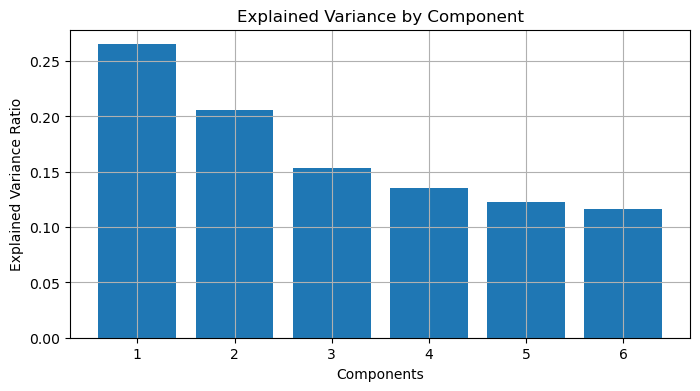

In [74]:
eigenvalues = mca.eigenvalues_
total_variance = sum(eigenvalues)
explained_variance_ratio = [eigenvalue / total_variance for eigenvalue in eigenvalues]

# Plotting the explained variance ratio
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Component')
plt.xticks(ticks=range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

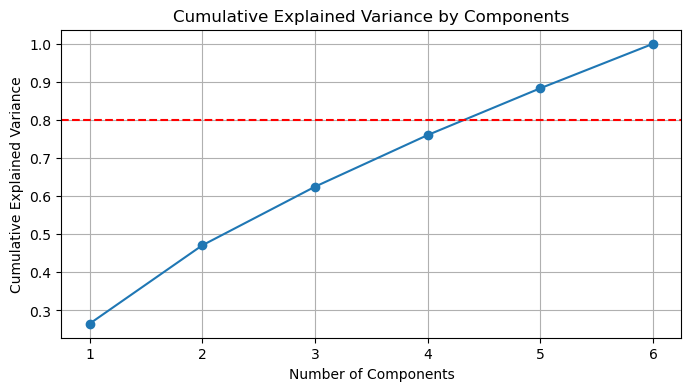

In [75]:
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plotting cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Components')
plt.axhline(y=0.8, color='r', linestyle='--')  # Example line at 80% variance explained
plt.xticks(ticks=range(1, len(cumulative_explained_variance) + 1))
plt.grid(True)
plt.show()

In [76]:
genre_mca_top6 = mca.transform(genre_df)
genre_mca_top6 = pd.DataFrame(genre_mca_top6)
#genre_mca_top6 = pd.concat([df, component_scores], axis=1)
genre_mca_top6.columns = ['Genre_MCA_1', 'Genre_MCA_2', 'Genre_MCA_3', 'Genre_MCA_4', 'Genre_MCA_5','Genre_MCA_6']
genre_mca_top6.head()

,Genre_MCA_1,Genre_MCA_2,Genre_MCA_3,Genre_MCA_4,Genre_MCA_5,Genre_MCA_6
0,-0.250349,0.495276,-0.123059,0.007292,-0.038275,0.406428
1,-0.385251,0.293562,-0.371245,-0.180010,0.198046,0.075225
2,-0.324223,-0.303682,0.332982,-0.100520,0.456613,0.150322
3,-0.132418,-0.312590,0.026812,1.109708,0.056176,-0.371363
4,-0.277562,-0.449194,0.100828,0.942775,0.074305,-0.323046


## Check for correlation among numerical variables

In [77]:
correlation_matrix = pd.concat([movie_df_new[['domestic_opening']+numerical_variables],genre_mca_top6],axis=1).corr()

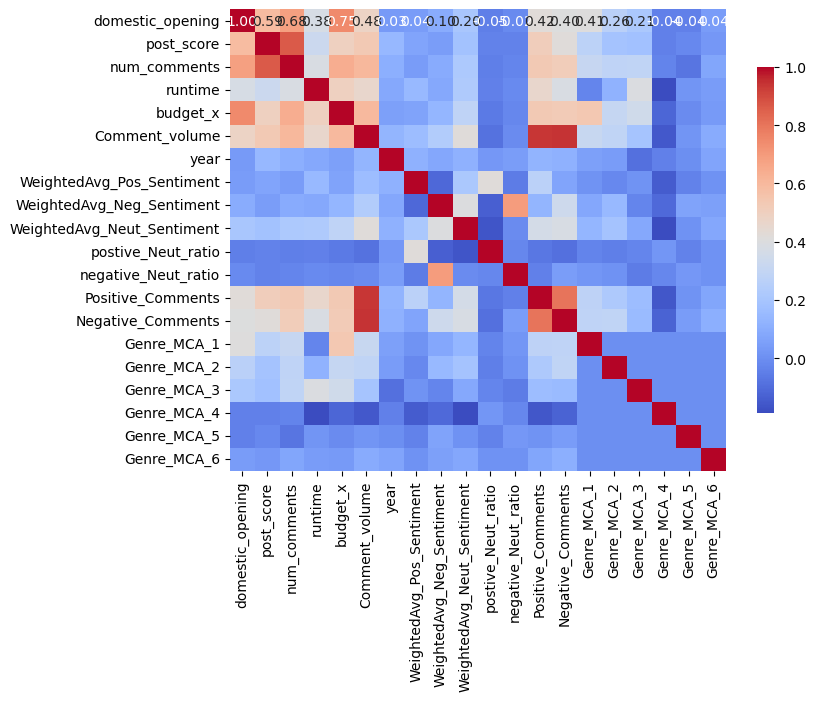

In [78]:
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns,
            cbar_kws={"shrink": .75})

# Show plot
plt.show()

In [79]:
bins = [0, 100, 120, 150, float('inf')]
labels = ['<100', '100-120', '121-150', '150+']

# Create the categorical variable
movie_df_new['runtime_category'] = pd.cut(movie_df_new['runtime'], bins=bins, labels=labels, right=False)

movie_df_new[['runtime','runtime_category']].sample(6)

,runtime,runtime_category
475,113,100-120
965,109,100-120
1349,101,100-120
507,88,<100
636,97,<100
1356,100,100-120


In [89]:
multi_cat_variables = ['Rating Category','runtime_category','qtr']
numerical_variables = ['domestic_opening','post_score','budget_x','num_comments','Comment_volume','year',
                      'WeightedAvg_Pos_Sentiment','WeightedAvg_Neg_Sentiment','WeightedAvg_Neut_Sentiment',
                       'postive_Neut_ratio','negative_Neut_ratio','big_production','Positive_Comments',
                       'Negative_Comments','missing_sentiment']

In [90]:
final_df = pd.concat([movie_df_new[['movie_searched']+ numerical_variables],movie_df_new[multi_cat_variables],
                      genre_mca_top6],axis=1)
final_df.info()#movie_searched

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1359 entries, 0 to 1358
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   movie_searched              1359 non-null   object  
 1   domestic_opening            1359 non-null   float64 
 2   post_score                  1359 non-null   int64   
 3   budget_x                    1359 non-null   int64   
 4   num_comments                1359 non-null   int64   
 5   Comment_volume              1359 non-null   float64 
 6   year                        1359 non-null   int64   
 7   WeightedAvg_Pos_Sentiment   1359 non-null   float64 
 8   WeightedAvg_Neg_Sentiment   1359 non-null   float64 
 9   WeightedAvg_Neut_Sentiment  1359 non-null   float64 
 10  postive_Neut_ratio          1359 non-null   float64 
 11  negative_Neut_ratio         1359 non-null   float64 
 12  big_production              1359 non-null   bool    
 13  Positive_Comments 

In [91]:
final_encoded_df = pd.get_dummies(final_df, columns=multi_cat_variables)
final_encoded_df.sample(4)

,movie_searched,domestic_opening,post_score,budget_x,num_comments,Comment_volume,year,WeightedAvg_Pos_Sentiment,WeightedAvg_Neg_Sentiment,WeightedAvg_Neut_Sentiment,...,Rating Category_Other,Rating Category_Teens+,runtime_category_<100,runtime_category_100-120,runtime_category_121-150,runtime_category_150+,qtr_1,qtr_2,qtr_3,qtr_4
298,Don't Think Twice,92835.0,505,0,64,61.0,2016,0.509382,0.175001,0.315617,...,0,0,1,0,0,0,0,0,1,0
634,Manchester by the Sea,256498.0,277,9000000,74,71.0,2016,0.426085,0.327991,0.245923,...,0,0,0,0,1,0,0,0,0,1
444,Hereditary,13575172.0,1233,10000000,282,274.0,2018,0.226484,0.390858,0.382657,...,0,0,0,0,1,0,0,1,0,0
234,Clifford the Big Red Dog,16627491.0,399,64000000,336,322.0,2021,0.194368,0.436277,0.369355,...,0,0,1,0,0,0,0,0,0,1


In [92]:
final_encoded_df.to_excel('Encoded_movie_data_cleaned.xlsx',index=False)

In [23]:
final_encoded_df1= pd.read_excel('Encoded_movie_data_cleaned_budget_imp.xlsx')
final_encoded_df1.head()

,movie_searched,domestic_opening,post_score,budget_x,Budget_new,Missing Budget,num_comments,Comment_volume,year,WeightedAvg_Pos_Sentiment,...,Rating Category_Other,Rating Category_Teens+,runtime_category_<100,runtime_category_100-120,runtime_category_121-150,runtime_category_150+,qtr_1,qtr_2,qtr_3,qtr_4
0,10 Cloverfield Lane,24727437,8953,15000000,15000000.0,0,1928,465,2016,0.314804,...,0,1,0,1,0,0,1,0,0,0
1,10x10,1430,2,0,0.0,1,2,2,2018,0.242466,...,1,0,1,0,0,0,0,1,0,0
2,12 Years a Slave,923715,1617,20000000,20000000.0,0,260,246,2013,0.352068,...,0,0,0,0,1,0,0,0,0,1
3,20 Feet from Stardom,54596,0,1000000,1000000.0,0,0,0,2013,0.000000,...,0,1,1,0,0,0,0,1,0,0
4,"20,000 Days on Earth",27879,42,0,0.0,1,8,8,2014,0.608336,...,0,0,1,0,0,0,0,0,1,0


In [26]:
final_encoded_df1.shape

(1359, 37)

In [24]:
#documentary movies
doc_movies = movie_df_new[movie_df_new['Documentary']==1]['movie_searched']
print(type(doc_movies))

<class 'pandas.core.series.Series'>


In [25]:
doc_movies = movie_df_new['Documentary']
doc_movies.shape

(1359,)

In [28]:
final_encoded_df1 = pd.concat([final_encoded_df1, doc_movies],axis=1)
final_encoded_df1.shape

(1359, 38)

In [29]:
final_encoded_df1.to_excel('Encoded_movie_data_with_budget_new.xlsx',index=False)